# Preprocess and Coding

### How to run: 
### 1.The last two cells are for preprocessing and generation of a gz file, which is to be transmitted. The latter cell is run to generate processed image and return an processed image in another window as feedback. The former cell will further process and encode the image into a compressed gz file.
### 2.Before running, we have 3 parameters to set: the 'threshold' in line 8/9 of 'predict' function and 'bytize' function(which are the last two function), and the 'downsize' in the former implementation cell. They are to be set properly to make sure gz file is small enough to be transmitted.
### Value for references:
### Marconi.bmp: threshold=0.5     downsize=2  PSNR=25.21
### createrLake.bmp: threshold=0.7 downsize=2  PSNR=22.24
### pauly.bmp: threshold=1.5 downsize=2  PSNR=11.08
### Isee.bmp: threshold=0.1 downsize=1  PSNR=17.43
### calBlue.bmp: directly transmitting, no need to encode. PSNR=inf
### --------------------------------------------------------------------------------------------
### Values used in competition:
### EE_test.tiff: threshold=0 downsize=1 PSNR= 8.57
### mid_test.tiff: threshold=0.2 downsize=2 PSNR=17.25

### 3. After setting the parameters, just run through and there will be a file named 'test.bnr.gz' generated in the directory folder. Please upload the .gz file to rasperry pi and go on runnning 'transmitter.ipynb'

In [40]:
import numpy as np
import math
import array
import bitarray
import matplotlib.pyplot as plt
from bitarray import bitarray
from array import *
from array import array
import cv2
from numpy import *
from math import *
import array
from array import array
import scipy
from scipy import signal
from numpy.fft import *
import gzip

In [3]:
def quantize2(maxi,n):
    p_lv=26
    n_lv=15
    if n>0:
        lv=n/maxi*p_lv
        return ceil(lv)
    else:
        if n<0:
            lv=n/maxi*n_lv
            if lv<-6:
                lv=-5
            return ceil(lv)
        else:
            return 0

In [4]:
def dequantize2(maxi,lv):
    p_lv=26
    n_lv=15
    if lv>0:
        return (lv-0.5)/p_lv*maxi
    else:
        if lv<=0:
            return (lv-0.5)/n_lv*maxi

In [5]:
def str2byte(string):
    import array
    from array import array
    bin_array = array("B")
    #bin_array=[]
    length = int(len(string)//8)
    for i in range (0, length):
        byte = string[8*i:8*(i+1)]
        bin_array.append(int(byte,2))
        i = i+1
    return bin_array

In [6]:
def dezigzag(L):
    #L = np.array([1,4,2,7,5,3,8,6,9])
    #L = np.array([1,5,2,9,6,3,13,10,7,4,14,11,8,15,12,16])
    n = np.sqrt(len(L))
    n = int(n)
    a = -1/2
    b = 2*n-1/2
    c = n-n*n
    
    M = []
    for i in range(1,n+1):
        for j in range(1,n+1):
            p = i+j-2
            if p <= n:
                q = 1/2*p*p+1/2*p
            else:
                q = a*p*p+b*p+c
            q = int(q)
            M.append(L[q+j-1-max(0,i+j-1-n)])
            j = j+1
        i = i+1
    
    M_old = np.reshape(M,(n,n))
    return M_old

In [7]:
def zigzag(win):
    [a,b]=win.shape
    n = a #array size 
    arr = [] 
    for i in range(2,2*n+1):  
        for j in range (max(1,i-n),min(i-1,n)+1): 
            arr.append(win[i-j-1,j-1]) 
            j = j+1 
        i = i+1 
    return arr  

In [8]:
def dec2binstr2(number,digit=6):
    return str(bin(number+5+32))[2:].zfill(digit)

In [9]:
def dec2binstr(number,digit=4):
    return str(bin(number))[2:].zfill(digit)

In [10]:
def binstr2dec2(arr,digit=6):
    if arr=='0': return 0
    else: 
        return (int(arr,2)-32-5)

In [11]:
def downsample(img,downsize=2):
    winsz=8*downsize
    ox,oy,c=img.shape

    s_x=int(ceil(ox/winsz))
    s_y=int(ceil(oy/winsz))
    x=s_x*winsz
    y=s_y*winsz

    img=pad(img,((0,x-ox),(0,y-oy),(0,0)),'constant')
    x_d=x//downsize
    y_d=y//downsize
    img_d=zeros([x_d,y_d,3])
    for i in range(0,x_d):
        for j in range(y_d):
            img_d[i,j]=img[i*downsize,j*downsize]

    return uint8(img_d)

In [12]:
def upsample(img,ox,oy):
    img_f=fftshift(fft2(img))
    print('original shape is',ox,oy)
    x,y=img_f.shape
    print('shape now is',x,y)
    print(ox-(ox-x)//2)
    img_f=pad(img_f,(((ox-x)//2,ox-x-(ox-x)//2),((oy-y)//2,oy-y-(oy-y)//2)),'constant')
    print('shape of FFT after extension is',img_f.shape)
    op=ifft2(ifftshift(img_f))
    print('shape of iFFT is',op.shape)
    op=op/op.max()*255
    return uint8(abs(op))

In [13]:
def readfrombnr(filename):
    with open(filename,"rb") as f:
        block = f.read()
        string = []
        for i in range(0,len(block)):
            string.append(dec2binstr(block[i],8))
            i = i+1
    f.close()
    string = "".join(string)
    return string

In [14]:
def writetobnr(msg,filename):
    #msg is a string contains only "0" & "1"
    increment = 8-len(msg)%8
    if increment ==8:
        increment = 0
    for i in range(0,increment):
        msg = msg + "0"
        i = i+1
    bytes_n = len(msg)//8
    bin_array = array("B")
    for j in range (0,bytes_n):
        Byte = msg[j*8:j*8+8]
        bin_array.append(int(Byte,2))
        j = j+1
    f = open(filename,"wb")
    f.write(bytes(bin_array))
    f.close()

In [15]:
def bnr2gzip(fname):
    with open(fname, 'rb') as f_in:
        with gzip.open(fname+".gz", 'wb') as f_out:
            f_out.writelines(f_in)
    f_in.close()
    f_out.close()

In [90]:
def predict(img):    
    #Read the image and float it
    img=float32(img)/255.0

    #Get the original length and window size
    ox,oy=img.shape
    winsz=8
    threshold=0.2 #for large images
    #threshold=0 #for small images
    digit=4

    #Padding the array and set up a void array
    s_x=int(ceil(ox/winsz))
    s_y=int(ceil(oy/winsz))
    x=s_x*winsz
    y=s_y*winsz

    img_dct=zeros((x,y))
    img_idct=zeros((x,y))
    img=pad(img,((0,x-ox),(0,y-oy)),'constant')

    #DCT
    for i in range(0,s_x):
        for j in range(0,s_y):
            img_dct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]=cv2.dct(img[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz])

    #Threshold
    o=img_dct
    temp=abs(img_dct)
    maxk=temp.max()
    img_dct=img_dct/maxk*32.0
    mask=abs(img_dct)>threshold
    img_dct=multiply(img_dct,mask)
    img_dct=img_dct/32.0*maxk
    print(mask.shape)
    print(sum(mask))

    #set the coefficients after the first zero as zero
    s_0=0
    bitarr = ""
    for i in range(0,s_x):
        for j in range(0,s_y):
            temp=img_dct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]
            temp_z=zigzag(temp)
            flag=False
            for k in range(0, len(temp_z)):
                if temp_z[k]==0:
                    flag=True
                if flag:
                    temp_z[k]=0
                else:
                    temp_z[k]=dequantize2(maxk,quantize2(maxk,temp_z[k]))
                    s_0+=1
            temp=dezigzag(temp_z)
            img_dct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]=temp
    mask=abs(img_dct)>0
    print(sum(mask))
    print(s_0)
    #IDCT
    for i in range(0,s_x):
        for j in range(0,s_y):
            img_idct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]=cv2.idct(img_dct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz])

    img_idct=img_idct*255
    img_idct=uint8(img_idct)
    med=scipy.signal.medfilt2d(img_idct,7)

    #Gussian Lowpass Filter
    freq=fftshift(fft2(med))
    fsz=freq.shape
    filt=zeros([fsz[0],fsz[1]])

    D=60
    for i in range(0,fsz[0]):
        for j in range(0,fsz[1]):
            filt[i,j]=exp(-(pow((i-fsz[0]//2),2)+pow(j-fsz[1]//2,2))/(2*pow(D,2)))

    freq2=multiply(freq,filt)
    img2=ifft2(freq2)

    #Iterative deconvolution
    temp=uint8(abs(img2))
    img2=scipy.signal.wiener(float64(temp))
    
    return uint8(abs(img2))

In [91]:
def bytize(img):
    #Read the image and float it
    img=float32(img)/255.0

    #Get the original length and window size
    ox,oy=img.shape
    winsz=8
    threshold=0.2 #for large images
    #threshold=0 #for small images
    digit=4

    #Padding the array and set up a void array
    s_x=int(ceil(ox/winsz))
    s_y=int(ceil(oy/winsz))
    x=s_x*winsz
    y=s_y*winsz

    img_dct=zeros((x,y))
    img_idct=zeros((x,y))
    img=pad(img,((0,x-ox),(0,y-oy)),'constant')

    #DCT
    for i in range(0,s_x):
        for j in range(0,s_y):
            img_dct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]=cv2.dct(img[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz])

    #Threshold
    o=img_dct
    temp=abs(img_dct)
    maxk=temp.max()
    img_dct=img_dct/maxk*32.0
    mask=abs(img_dct)>threshold
    img_dct=multiply(img_dct,mask)
    img_dct=img_dct/32.0*maxk
    print(mask.shape)
    print(sum(mask))

    #set the coefficients after the first zero as zero
    s_0=0
    bitarr = ""
    winnum=0
    for i in range(0,s_x):
        for j in range(0,s_y):
            temp=img_dct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]
            temp_z=zigzag(temp)
            flag=False
            for k in range(0, len(temp_z)):
                #print('coefficient number=',s_0)
                #print('win number=',winnum)
                #print('length of birarray',len(bitarr))
                #if (len(bitarr)-6*s_0-winnum==0): print('correct')
                if k==len(temp_z)-1:
                    temp_z[k]=0
                if temp_z[k]==0:
                    flag=True
                    bitarr=bitarr+'0'
                    #winnum+=1
                    #print('coefficient=0,index+1',len(bitarr))
                    #print('winnum+1',winnum)
                    break
                else:
                    bitarr=bitarr+dec2binstr2(quantize2(maxk,temp_z[k]),6)
                    #print('coefficient=',quantize2(maxk,temp_z[k]))
                    #print('coefficient~=0,index+6',len(bitarr))
                    s_0=s_0+1
                    #print('number of coefficient+1',s_0)
            temp=dezigzag(temp_z)
            img_dct[i*winsz:(i+1)*winsz,j*winsz:(j+1)*winsz]=temp
    print(s_0)
    return bitarr,maxk

(346, 768, 3)
(176, 384)
16925
4241
4241


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:950: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:950: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


(176, 384)
18221
4420
4420
(176, 384)
19025
4555
4555


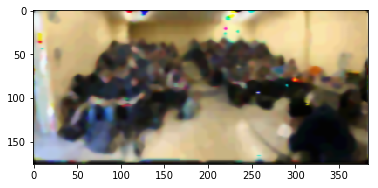

In [92]:
#The former implementation cell
#Read an image, preprocessing it and return its feedback

img=cv2.imread('mid_test.tiff',1)
print(img.shape)
downsize=2 #for large images
#downsize=1 #for small images

winsz=8
ox,oy,c=img.shape

img=downsample(img,downsize)
x,y,c=img.shape

#s_x=int(ceil(ox/winsz))
#s_y=int(ceil(oy/winsz))
#x=s_x*winsz
#y=s_y*winsz

height=x
width=y
img2=zeros([x,y,c])
img_R=img[:,:,0]
img_G=img[:,:,1]
img_B=img[:,:,2]

img_R2=predict(img_R)
img_G2=predict(img_G)
img_B2=predict(img_B)
img2[:,:,0]=img_R2
img2[:,:,1]=img_G2
img2[:,:,2]=img_B2
pltimg=plt.imshow(cv2.cvtColor(uint8(img2), cv2.COLOR_BGR2RGB))
plt.show()


In [93]:
#The latter implementation cell
#Further coding the image into test.bnr.gz file

hstr=dec2binstr(height,11)
wstr=dec2binstr(width,11)
oxstr=dec2binstr(ox,11)
oystr=dec2binstr(oy,11)

strR,maxR=bytize(img_R)
print(len(strR))
strG,maxG=bytize(img_G)
print(len(strG))
strB,maxB=bytize(img_B)
print(len(strB))

strmaxR=dec2binstr(int(floor(maxR*1000)),13)
strmaxG=dec2binstr(int(floor(maxG*1000)),13)
strmaxB=dec2binstr(int(floor(maxB*1000)),13)

arr=oxstr+oystr+hstr+wstr+strmaxR+strR+strmaxG+strG+strmaxB+strB
writetobnr(arr,"test.bnr")
bnr2gzip("test.bnr")

(176, 384)
16925
4241
26502
(176, 384)
18221
4420
27576
(176, 384)
19025
4555
28386
